In [62]:
jax.config.update("jax_disable_jit", False)
# jax.config.update("jax_debug_nans", True)

In [1]:
# Taken from:
# https://github.com/corl-team/xland-minigrid/blob/main/training/train_single_task.py

import os
import time
import gymnax
import jax
import jax.numpy as jnp
import jax.tree_util
import optax
import wandb
from flax.jax_utils import replicate, unreplicate
from flax.training.train_state import TrainState
import distrax
import flax
import flax.linen as nn
from MetaLearnCuriosity.agents.nn import AtariBYOLPredictor, BYOLEncoder, BYOLTarget, OpenScannedRNN, CloseScannedRNN
from MetaLearnCuriosity.checkpoints import Save
from MetaLearnCuriosity.logger import WBLogger
from MetaLearnCuriosity.utils import BYOLTransition as Transition
from MetaLearnCuriosity.utils import byol_normlise_prior_int_rewards,  BYOLRewardNorm
from MetaLearnCuriosity.utils import (
    make_obs_gymnax_discrete,
    process_output_general,
)
from MetaLearnCuriosity.wrappers import (
    FlattenObservationWrapper,
    LogWrapper,
    VecEnv,
)
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, TypedDict
import functools
import math
from typing import Sequence, TypedDict

import distrax
import numpy as np


environments = [
    "Asterix-MinAtar",
    # "Breakout-MinAtar",
    # "Freeway-MinAtar",
    # "SpaceInvaders-MinAtar",
]
config = {
    "RUN_NAME": "minatar_baseline_ppo",
    "SEED": 42,
    "NUM_SEEDS": 2,
    "LR": 5e-3,
    "NUM_ENVS": 64,
    "NUM_STEPS": 128,
    "TOTAL_TIMESTEPS": 1e5,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": 8,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.01,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu",
    "ANNEAL_LR": True,
    "DEBUG": False,
    "PRED_LR": 1e-4,
    "ENCODER_LR": 1e-4,
    "EMA_PARAMETER": 0.99,
    "REW_NORM_PARAMETER": 0.99,
    # "INT_LAMBDA": 0.006,
}

class PPOActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh

        actor_mean = nn.Dense(64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(
            x
        )
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        pi = distrax.Categorical(logits=actor_mean)

        critic = nn.Dense(64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(x)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(critic)

        return pi, jnp.squeeze(critic, axis=-1)

A Google TPU may be present on this machine, but either a TPU-enabled jaxlib or libtpu is not installed. Falling back to cpu.
/home/batsy/MetaLearnCuriosity/tpu_curiosax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


: 

In [64]:
def make_config_env(config, env_name):
    config["ENV_NAME"] = env_name
    num_devices = jax.local_device_count()
    assert config["NUM_ENVS"] % num_devices == 0
    config["NUM_ENVS_PER_DEVICE"] = config["NUM_ENVS"] // num_devices
    config["TOTAL_TIMESTEPS_PER_DEVICE"] = config["TOTAL_TIMESTEPS"] // num_devices
    # config["EVAL_EPISODES_PER_DEVICE"] = config["EVAL_EPISODES"] // num_devices
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS_PER_DEVICE"] // config["NUM_STEPS"] // config["NUM_ENVS_PER_DEVICE"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ENVS_PER_DEVICE"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    config["TRAINING_HORIZON"] = (
        config["TOTAL_TIMESTEPS_PER_DEVICE"] // config["NUM_ENVS_PER_DEVICE"]
    )
    env, env_params = gymnax.make(config["ENV_NAME"])
    env = FlattenObservationWrapper(env)
    env = LogWrapper(env)
    env = VecEnv(env)

    return config, env, env_params


def ppo_make_train(rng):
    def linear_schedule(count):
        frac = (
            1.0
            - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"]))
            / config["NUM_UPDATES"]
        )
        return config["LR"] * frac

    # INIT NETWORK
    network = PPOActorCritic(env.action_space(env_params).n, activation=config["ACTIVATION"])
    pred = AtariBYOLPredictor(64, env.action_space(env_params).n)
    target = BYOLTarget(64)
    encoder = BYOLEncoder(64)

    # KEYS
    rng, _rng = jax.random.split(rng)
    rng, _tar_rng = jax.random.split(rng)
    rng, _en_rng = jax.random.split(rng)
    rng, _pred_rng = jax.random.split(rng)

    #INPUTS 
    init_x = jnp.zeros((1,config["NUM_ENVS_PER_DEVICE"],*env.observation_space(env_params).shape))
    init_en_x = jnp.zeros((1,config["NUM_ENVS_PER_DEVICE"],64))
    action = jnp.zeros((1,config["NUM_ENVS_PER_DEVICE"]), dtype=jnp.int32)
    open_init_hstate = OpenScannedRNN.initialize_carry(config["NUM_ENVS_PER_DEVICE"], 16)
    close_init_hstate = CloseScannedRNN.initialize_carry(config["NUM_ENVS_PER_DEVICE"], 16)
    init_bt = jnp.zeros((1,config["NUM_ENVS_PER_DEVICE"],16))
    init_input=(init_bt,init_en_x,action)

    #PARAMS
    network_params = network.init(_rng, init_en_x)
    target_params = target.init(_tar_rng, init_x)
    encoder_params = encoder.init(_en_rng, init_x)
    pred_params = pred.init(_pred_rng, close_init_hstate, open_init_hstate,init_input)

    if config["ANNEAL_LR"]:
        tx = optax.chain(
            optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
            optax.adam(learning_rate=linear_schedule, eps=1e-5),
        )
    else:
        tx = optax.chain(
            optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
            optax.adam(config["LR"], eps=1e-5),
        )
    pred_tx = optax.chain(
            optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
            optax.adam(config["PRED_LR"], eps=1e-5),
    )
    en_tx = optax.chain(
            optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
            optax.adam(config["ENCODER_LR"], eps=1e-5),
    )
    train_state = TrainState.create(
        apply_fn=network.apply,
        params=network_params,
        tx=tx,
    )
    pred_state = TrainState.create(
        apply_fn = pred.apply,
        params = pred_params,
        tx=pred_tx,
    )
    encoder_state = TrainState.create(
        apply_fn = encoder.apply,
        params = encoder_params,
        tx=en_tx,
    )

    rng = jax.random.split(rng, jax.local_device_count())

    return rng, train_state, pred_state, encoder_state, target_params,close_init_hstate,open_init_hstate, init_bt


def train(rng, train_state, pred_state, encoder_state, target_params,close_hstate,open_hstate,bt):
    target=BYOLTarget(64)
    byol_reward_norm_params = BYOLRewardNorm(0,0,1,0)
    # INIT ENV
    rng, _rng = jax.random.split(rng)
    reset_rng = jax.random.split(_rng, config["NUM_ENVS_PER_DEVICE"])
    obsv, env_state = env.reset(reset_rng, env_params)

    update_target_counter = 0
    # TRAIN LOOP
    def _update_step(runner_state, unused):
        # COLLECT TRAJECTORIES
        
        def _env_step(runner_state, unused):
            train_state,pred_state,encoder_state,target_params, close_hstate,open_hstate,bt, byol_reward_norm_params,env_state, last_obs,update_target_counter,  rng = runner_state

            # SELECT ACTION
            en_last_obs = encoder_state.apply_fn(encoder_state.params, last_obs)
            rng, _rng = jax.random.split(rng)
            pi, value = train_state.apply_fn(train_state.params, en_last_obs)
            action = pi.sample(seed=_rng)
            log_prob = pi.log_prob(action)

            # STEP ENV
            rng, _rng = jax.random.split(rng)
            rng_step = jax.random.split(_rng, config["NUM_ENVS_PER_DEVICE"])
            obsv, env_state, reward, done, info = env.step(rng_step, env_state, action, env_params)

            # INT REWARD
            pred_in = (bt,en_last_obs[np.newaxis, :],action[np.newaxis, :])
            pred_obs, bt, close_hstate, open_hstate = pred_state.apply_fn(pred_state.params, close_hstate,open_hstate, pred_in)
            tar_obs = target.apply(target_params, obsv)
            pred_norm = (pred_obs.squeeze(0)) / (jnp.linalg.norm(pred_obs.squeeze(0), axis=-1, keepdims=True))
            tar_norm = jax.lax.stop_gradient(
                (tar_obs) / (jnp.linalg.norm(tar_obs, axis=-1, keepdims=True))
            )
            int_reward = jnp.square(jnp.linalg.norm((pred_norm - tar_norm), axis=-1)) * (
                1 - done
            )



            transition = Transition(done, action, value, reward, int_reward,log_prob, last_obs, obsv,info)
            runner_state = (train_state,pred_state,encoder_state,target_params, close_hstate,open_hstate,bt, byol_reward_norm_params, env_state, obsv, update_target_counter,rng)
            return runner_state, transition
        
        close_initial_hstate, open_initial_hstate, initial_bt= runner_state[4:7]
        runner_state, traj_batch = jax.lax.scan(_env_step, runner_state, None, config["NUM_STEPS"])

        # CALCULATE ADVANTAGE
        train_state,pred_state,encoder_state,target_params, close_hstate,open_hstate,bt, byol_reward_norm_params, env_state, last_obs, update_target_counter,rng = runner_state
        update_target_counter+=1
        en_last_obs = encoder_state.apply_fn(encoder_state.params, last_obs)
        _, last_val = train_state.apply_fn(train_state.params, en_last_obs)

        def _calculate_gae(traj_batch, last_val, byol_reward_norm_params):
            prior_norm_int_reward, byol_reward_norm_params = byol_normlise_prior_int_rewards(traj_batch.int_reward,byol_reward_norm_params, config["REW_NORM_PARAMETER"] )
            norm_traj_batch = Transition(
                traj_batch.done,
                traj_batch.action,
                traj_batch.value,
                traj_batch.reward,
                prior_norm_int_reward,
                traj_batch.log_prob,
                traj_batch.obs,
                traj_batch.next_obs,
                traj_batch.info,
            )
            def _get_advantages(gae_and_next_value, transition):
                gae, next_value = gae_and_next_value
                done, value, reward, int_reward = (
                    transition.done,
                    transition.value,
                    transition.reward,
                    transition.int_reward
                )
                delta = (reward+config["INT_LAMBDA"]*int_reward) + config["GAMMA"] * next_value * (1 - done) - value
                gae = delta + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                return (gae, value), gae

            _, advantages = jax.lax.scan(
                _get_advantages,
                (jnp.zeros_like(last_val), last_val),
                norm_traj_batch,
                reverse=True,
                unroll=16,
            )
            return advantages, advantages + traj_batch.value, prior_norm_int_reward, byol_reward_norm_params

        advantages, targets, prior_norm_int_reward, byol_reward_norm_params = _calculate_gae(traj_batch, last_val, byol_reward_norm_params)

        # UPDATE NETWORK
        def _update_epoch(update_state, unused):
            def _update_minbatch(train_states, batch_info):
                traj_batch, advantages, targets,bt,close_hstate,open_hstate = batch_info
                train_state, pred_state, encoder_state, target_params = train_states

                def _pred_loss(pred_params, encoder_params, target_params, traj_batch , bt,close_hstate,open_hstate):
                    en_last_obs = encoder_state.apply_fn(encoder_params, traj_batch.obs)
                    # en_obs = encoder_state.apply_fn(encoder_params, traj_batch.next_obs)
                    pred_in = (bt,en_last_obs,traj_batch.action)
                    pred_obs, _,_,_= pred_state.apply_fn(pred_params, close_hstate[0],open_hstate[0], pred_in)
                    tar_obs = target.apply(target_params, traj_batch.obs)
                    pred_norm = (pred_obs) / (jnp.linalg.norm(pred_obs, axis=-1, keepdims=True))
                    tar_norm = jax.lax.stop_gradient(
                        (tar_obs) / (jnp.linalg.norm(tar_obs, axis=-1,keepdims=True))
                    )
                    loss = jnp.square(jnp.linalg.norm((pred_norm - tar_norm), axis=-1)) * (
                        1 - traj_batch.done
                    )
                    return loss.mean()
                
                def _encoder_loss(train_params, encoder_params,traj_batch, gae, targets,pred_params, target_params, bt,close_hstate,open_hstate):
                    rl_loss,_ = _loss_fn(train_params, encoder_params,traj_batch, gae, targets)
                    pred_loss = _pred_loss(pred_params, encoder_params, target_params, traj_batch , bt,close_hstate,open_hstate)

                    return rl_loss+pred_loss

                def _loss_fn(train_params, encoder_params,traj_batch, gae, targets):
                    # RERUN NETWORK
                    en_last_obs = encoder_state.apply_fn(encoder_params, traj_batch.obs)
                    pi, value = train_state.apply_fn(train_params, en_last_obs)
                    log_prob = pi.log_prob(traj_batch.action)

                    # CALCULATE VALUE LOSS
                    value_pred_clipped = traj_batch.value + (value - traj_batch.value).clip(
                        -config["CLIP_EPS"], config["CLIP_EPS"]
                    )
                    value_losses = jnp.square(value - targets)
                    value_losses_clipped = jnp.square(value_pred_clipped - targets)
                    value_loss = 0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()

                    # CALCULATE ACTOR LOSS
                    ratio = jnp.exp(log_prob - traj_batch.log_prob)
                    gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                    loss_actor1 = ratio * gae
                    loss_actor2 = (
                        jnp.clip(
                            ratio,
                            1.0 - config["CLIP_EPS"],
                            1.0 + config["CLIP_EPS"],
                        )
                        * gae
                    )
                    loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                    loss_actor = loss_actor.mean()
                    entropy = pi.entropy().mean()

                    total_loss = (
                        loss_actor + config["VF_COEF"] * value_loss - config["ENT_COEF"] * entropy
                    )
                    return total_loss, (value_loss, loss_actor, entropy)

                (loss, (vloss, aloss, entropy)), grads = jax.value_and_grad(_loss_fn, has_aux=True)(
                    train_state.params, encoder_state.params, traj_batch, advantages, targets
                )
                pred_loss, pred_grads = jax.value_and_grad(_pred_loss)(pred_state.params, encoder_state.params, target_params, traj_batch , bt,close_hstate,open_hstate)
                encoder_loss, encoder_grads = jax.value_and_grad(_encoder_loss,1)(train_state.params, encoder_state.params,traj_batch, advantages, targets,pred_state.params, target_params, bt,close_hstate,open_hstate)
                (loss, vloss, aloss, entropy,pred_loss,encoder_loss, grads,pred_grads,encoder_grads) = jax.lax.pmean(
                    (loss, vloss, aloss, entropy, pred_loss,encoder_loss, grads,pred_grads,encoder_grads), axis_name="devices"
                )
                train_state = train_state.apply_gradients(grads=grads)
                pred_state = pred_state.apply_gradients(grads=pred_grads)
                encoder_state = encoder_state.apply_gradients(grads=encoder_grads)

                def update_conditionally(update_target_counter, target_params, encoder_params):
                    def true_fun(_):
                        # Perform the EMA update
                        return jax.tree_util.tree_map(
                            lambda tp, op: tp * config["EMA_PARAMETER"] + (1 - config["EMA_PARAMETER"]) * op,
                            target_params,
                            encoder_params
                        )

                    def false_fun(_):
                        # Return the old target_params unchanged
                        return target_params

                    # Conditionally update every 10 steps
                    return jax.lax.cond(
                        update_target_counter % 10 == 0,
                        true_fun,
                        false_fun,
                        None  # The argument passed to true_fun and false_fun, `_` in this case is unused
                    )

                # Use this function in your update step, pass the appropriate parameters
                target_params = update_conditionally(update_target_counter, target_params, encoder_state.params)


                return (train_state,pred_state,encoder_state,target_params), (loss, (vloss, aloss, entropy), pred_loss, encoder_loss)

            train_state,pred_state,encoder_state, target_params,bt, close_hstate,open_hstate, traj_batch, advantages, targets,update_target_counter, rng = update_state
            rng, _rng = jax.random.split(rng)
            permutation = jax.random.permutation(_rng, config["NUM_ENVS_PER_DEVICE"])
            batch = (traj_batch, advantages, targets, bt, close_hstate, open_hstate)

            shuffled_batch = jax.tree_util.tree_map(
                lambda x: jnp.take(x, permutation, axis=0), batch
            )

            minibatches = jax.tree_util.tree_map(
                lambda x: jnp.swapaxes(
                    jnp.reshape(
                        x,
                        [x.shape[0], config["NUM_MINIBATCHES"], -1]
                        + list(x.shape[2:]),
                    ),
                    1,
                    0,
                ),
                shuffled_batch,
            )

            (train_state,pred_state,encoder_state,target_params), total_loss = jax.lax.scan(_update_minbatch, (train_state,pred_state,encoder_state,target_params), minibatches)
            update_state = (train_state,pred_state,encoder_state, target_params,bt, close_hstate,open_hstate, traj_batch, advantages, targets, update_target_counter,rng)
            return update_state, total_loss

        update_state = (train_state,pred_state,encoder_state, target_params,initial_bt, close_initial_hstate[None, :],open_initial_hstate[None, :], traj_batch, advantages, targets, update_target_counter,rng)
        update_state, loss_info = jax.lax.scan(
            _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
        )
        train_state,pred_state, encoder_state, target_params = update_state[:4]
        metric = traj_batch.info
        rng = update_state[-1]
        if config.get("DEBUG"):

            def callback(info):
                return_values = info["returned_episode_returns"][info["returned_episode"]]
                timesteps = (
                    info["timestep"][info["returned_episode"]] * config["NUM_ENVS_PER_DEVICE"]
                )
                for t in range(len(timesteps)):
                    print(f"global step={timesteps[t]}, episodic return={return_values[t]}")

            jax.debug.callback(callback, metric)

        runner_state = (train_state,pred_state,encoder_state,target_params, close_hstate,open_hstate,bt, byol_reward_norm_params, env_state, last_obs,update_target_counter, rng)
        return runner_state, (metric, loss_info,traj_batch.int_reward, prior_norm_int_reward)

    rng, _rng = jax.random.split(rng)
    runner_state = (train_state, pred_state,encoder_state,target_params, close_hstate,open_hstate,bt, byol_reward_norm_params,env_state, obsv,update_target_counter, _rng)
    runner_state, extra_info = jax.lax.scan(_update_step, runner_state, None, config["NUM_UPDATES"])
    metric, rl_total_loss, int_reward, norm_int_reward = extra_info
    return {
        "train_state": runner_state[:3],
        "metrics": metric,
        "rl_total_loss": rl_total_loss[0],
        "rl_value_loss": rl_total_loss[1][0],
        "rl_actor_loss": rl_total_loss[1][1],
        "rl_entrophy_loss": rl_total_loss[1][2],
        "pred_loss": rl_total_loss[2],
        "encoder_loss": rl_total_loss[3],
        "int_reward":int_reward,
        "norm_int_reward": norm_int_reward,
        "byol_reward_norm_params":byol_reward_norm_params,
        "update_target_counter": update_target_counter,
    }

In [65]:
# lambda_values=jnp.array([ 000.1,0.01,0.1, 0.003,0.005,0.02,0.03,0.05,0.2,0.5]).sort()
lambda_values=jnp.array([0.01]).sort()

In [66]:
y_values = {}
for lambda_value in lambda_values:
    y_values[lambda_value] = {}  # Use float(lambda_value) to ensure dictionary keys are serializable
    config["INT_LAMBDA"]=lambda_value
    for env_name in environments:
        rng = jax.random.PRNGKey(config["SEED"])
        t = time.time()
        config, env, env_params = make_config_env(config, env_name)
        print(f"Training in {config['ENV_NAME']}")

        if config["NUM_SEEDS"] > 1:
            rng = jax.random.split(rng, config["NUM_SEEDS"])
            rng, train_state,pred_state, encoder_state, target_params,close_init_hstate,open_init_hstate, init_bt = jax.jit(jax.vmap(ppo_make_train, out_axes=(1,0,0,0,0,0,0,0)))(rng)
            open_init_hstate = replicate(open_init_hstate, jax.local_devices())
            close_init_hstate = replicate(close_init_hstate, jax.local_devices())
            train_state = replicate(train_state, jax.local_devices())
            pred_state = replicate(pred_state, jax.local_devices())
            encoder_state = replicate(encoder_state, jax.local_devices())
            target_params = replicate(target_params, jax.local_devices())
            init_bt = replicate(init_bt, jax.local_devices())
            train_fn = jax.vmap(train)
            train_fn = jax.pmap(train_fn, axis_name="devices")
            print(f"Training in {config['ENV_NAME']}")
            t = time.time()
            output = jax.block_until_ready(train_fn(rng, train_state, pred_state, encoder_state, target_params,close_init_hstate,open_init_hstate, init_bt ))
            elapsed_time = time.time() - t


        else:
            rng, train_state,pred_state, encoder_state, target_params,close_init_hstate,open_init_hstate, init_bt  = ppo_make_train(rng)
            open_init_hstate = replicate(open_init_hstate, jax.local_devices())
            close_init_hstate = replicate(close_init_hstate, jax.local_devices())
            train_state = replicate(train_state, jax.local_devices())
            pred_state = replicate(pred_state, jax.local_devices())
            encoder_state = replicate(encoder_state, jax.local_devices())
            target_params = replicate(target_params, jax.local_devices())
            init_bt = replicate(init_bt, jax.local_devices())
            train_fn = jax.pmap(train, axis_name="devices")
            t = time.time()
            output = jax.block_until_ready(train_fn(rng, train_state, pred_state, encoder_state, target_params,close_init_hstate,open_init_hstate, init_bt ))
            elapsed_time = time.time() - t

        print((time.time() - t)/60)
        # Assuming `output` is your array
        epi_ret = output["metrics"]["returned_episode_returns"].mean(0).mean(0).mean(-1).reshape(-1)
        int_rew = output["int_reward"].mean(0).mean(0).mean(-1).reshape(-1)
        int_norm_rew = output["norm_int_reward"].mean(0).mean(0).mean(-1).reshape(-1)
        pred_loss = unreplicate(output["pred_loss"]).mean(-1).mean(0).mean(-1)
        encoder_loss = unreplicate(output["encoder_loss"]).mean(-1).mean(0).mean(-1)

        # Use the last element of each row from 'epi_ret' as y-values
        y_values[lambda_value][env_name] = (epi_ret,int_rew,int_norm_rew,pred_loss,encoder_loss)

# Print or process `y_values` as needed


Training in Asterix-MinAtar
Training in Asterix-MinAtar


/home/batsy/MetaLearnCuriosity/tpu_curiosax/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/home/batsy/MetaLearnCuriosity/tpu_curiosax/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/home/batsy/MetaLearnCuriosity/tpu_curiosax/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/home/batsy/MetaLearnCuri

In [61]:
y_values[0.009999999776482582]['Asterix-MinAtar'][0]

Array([0.       , 0.       , 0.       , ..., 0.3046875, 0.3125   ,
       0.3125   ], dtype=float32)

In [42]:
import matplotlib.pyplot as plt

# Metric names corresponding to the data stored in y_values
metric_names = [
    "Episode Returns",
    "Intrinsic Reward",
    "Normalized Intrinsic Reward",
    "Pred Loss",
    "Encoder Loss",
]

# Initialize plotting
for env_name in environments:
    num_metrics = len(metric_names)
    fig, axs = plt.subplots(num_metrics, 1, figsize=(12, 6 * num_metrics), sharex=True)
    fig.suptitle(f'Training Metrics Over Time for {env_name}')

    # Iterate over each metric
    for idx, metric_name in enumerate(metric_names):
        ax = axs[idx] if num_metrics > 1 else axs

        # Plot each lambda's data for this metric
        plotted = False
        for lambda_value in lambda_values:
            lambda_key = float(lambda_value)  # Ensure float key matches dictionary keys
            if lambda_key in y_values and env_name in y_values[lambda_key]:
                metric_data = y_values[lambda_key][env_name][idx]
                if len(metric_data) > 0:
                    x_axis = range(len(metric_data))
                    ax.plot(x_axis, metric_data, label=f'Lambda={lambda_value:.2f}')
                    plotted = True

        # Only add a legend if data was actually plotted
        if plotted:
            ax.set_title(metric_name)
            ax.set_xlabel("Training Steps")
            ax.set_ylabel(metric_name)
            ax.legend()
        else:
            ax.set_title(f"{metric_name} (no data)")
            ax.set_xlabel("Training Steps")
            ax.set_ylabel(metric_name)

    # Adjust layout and save the figure
    plt.subplots_adjust(hspace=0.4)  # Adjust vertical spacing between plots
    plt.savefig(f"{env_name}_metrics_over_time.png")
    plt.close(fig)



In [43]:
# Initialize plotting
for env_name in environments:
    # Prepare data for plotting
    final_returns = []
    labels = []

    # Collect final episode returns for each lambda value
    for lambda_value in lambda_values:
        lambda_key = float(lambda_value)  # Ensure float key matches dictionary keys
        if lambda_key in y_values and env_name in y_values[lambda_key]:
            epi_returns = y_values[lambda_key][env_name][0]  # Assuming index 0 is Episode Returns
            if len(epi_returns) > 0:
                final_returns.append(epi_returns[-1])  # Get the last value
                labels.append(f'Lambda={lambda_value:.2f}')

    # Plotting
    if final_returns:  # Check if there are any final returns to plot
        plt.figure(figsize=(10, 6))
        plt.bar(labels, final_returns, color='skyblue')
        plt.title(f'Final Episode Returns vs. Lambda for {env_name}')
        plt.xlabel('Lambda Value')
        plt.ylabel('Final Episode Return')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.savefig(f"{env_name}_final_episode_returns_vs_lambda.png")
        plt.close()  # Close the plot to free up memory
    else:
        print(f"No final episode return data available for {env_name}.")


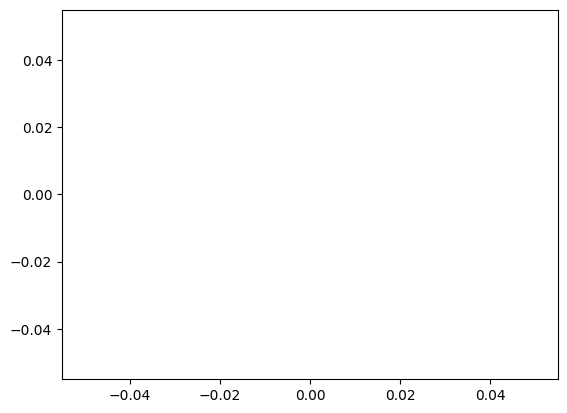

In [47]:
plt.plot(y_values[0.009999999776482582]['Asterix-MinAtar'][4])
plt.show()